In [20]:
# libraries 

import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import cv2

import tensorflow as tf
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd 
import numpy as np

from sklearn.utils import class_weight

import sklearn


In [24]:
train_dir = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/binary/train/'
val_dir = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/binary/val/'
test_dir = '/Users/sudeshgurung/Msc-Data_Analytics/dissertation/Project/dataset/binary/test'

## Variables


In [25]:
IMAGE_SIZE = 256
EPOCH = 30

# Image Pre-processing 

In [26]:
def custom_preprocessing(image):
    return cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 5) ,-4 ,128)
    
    

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = custom_preprocessing
)

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
#     color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=24,
)

Found 2930 images belonging to 2 classes.


In [29]:
class_labels = list(train_generator.class_indices.keys())
class_labels

['DR', 'No_DR']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

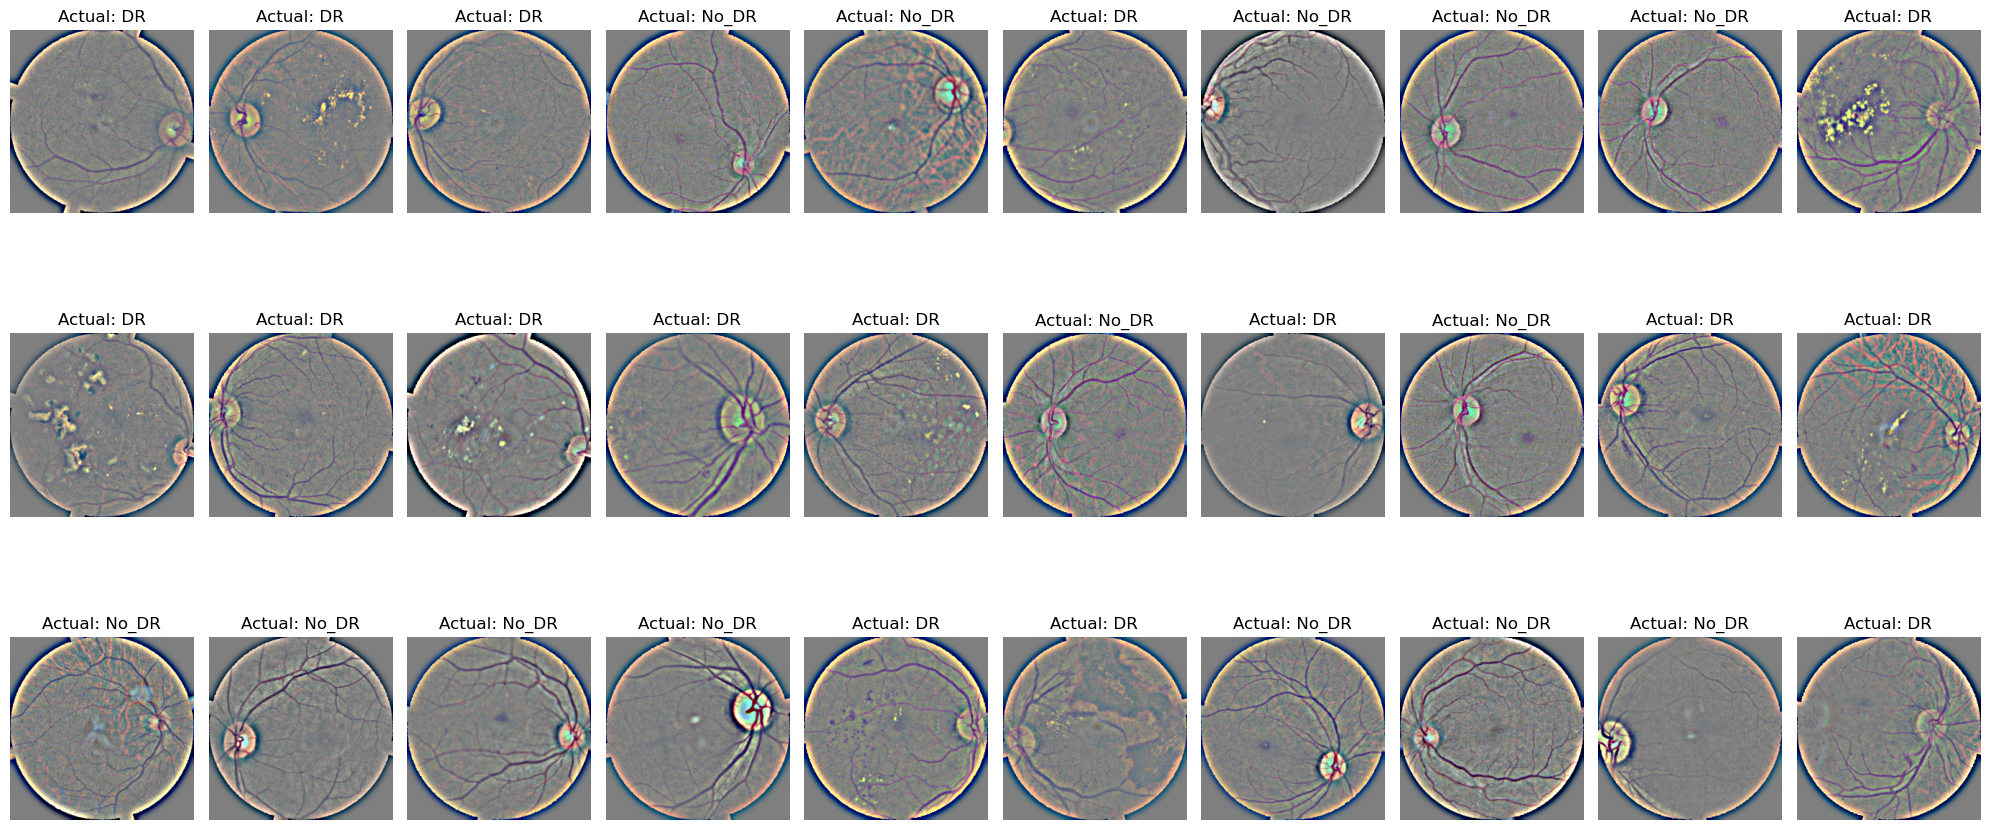

In [30]:
images, labels = train_generator.next()

# Display the first 30 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title('Actual: {}'.format(class_labels[int(labels[i])]))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [31]:
# for validation 
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = custom_preprocessing
)

In [32]:
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=24,
#     color_mode='grayscale',
)

Found 366 images belonging to 2 classes.


In [33]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = custom_preprocessing
)

In [34]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=24,
)

Found 366 images belonging to 2 classes.


# Model creation

In [38]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image

In [39]:
xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
)

2023-07-30 23:17:29.147436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
for layer in xception_model.layers:
    layer.trainable = False

In [41]:
model = Sequential()
model.add(xception_model)
model.add(Flatten()),
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [42]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import resnet50

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               6

In [48]:
from keras.callbacks import ReduceLROnPlateau

In [49]:
# hyper-parameters
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,
                              verbose=0, mode='auto', min_delta=0.0001,
                              cooldown=0, min_lr=0)
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [50]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 0.9792780748663101, 1: 1.0216178521617851}

In [51]:
h = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr,early_stopping],
#     class_weight=class_weights

)

Epoch 1/30
91/91 [==============================] - 1430s 16s/step - loss: 2.4963 - accuracy: 0.7598 - val_loss: 0.3564 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - 1589s 17s/step - loss: 0.3849 - accuracy: 0.8640 - val_loss: 0.2381 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 3/30
91/91 [==============================] - 1582s 17s/step - loss: 0.2832 - accuracy: 0.8889 - val_loss: 0.1713 - val_accuracy: 0.9290 - lr: 0.0010
Epoch 4/30
91/91 [==============================] - 1623s 18s/step - loss: 0.2560 - accuracy: 0.9017 - val_loss: 0.2200 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 5/30
91/91 [==============================] - 1620s 18s/step - loss: 0.2481 - accuracy: 0.9023 - val_loss: 0.1765 - val_accuracy: 0.9403 - lr: 0.0010
Epoch 6/30
91/91 [==============================] - 1546s 17s/step - loss: 0.2336 - accuracy: 0.9144 - val_loss: 0.1809 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 7/30
91/91 [==============================] - 1378s 15s/st

In [52]:
def visualize_performance(history):
    #Visualizing the training performance
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='val_Loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    plt.title('Loss evolution')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evolution')

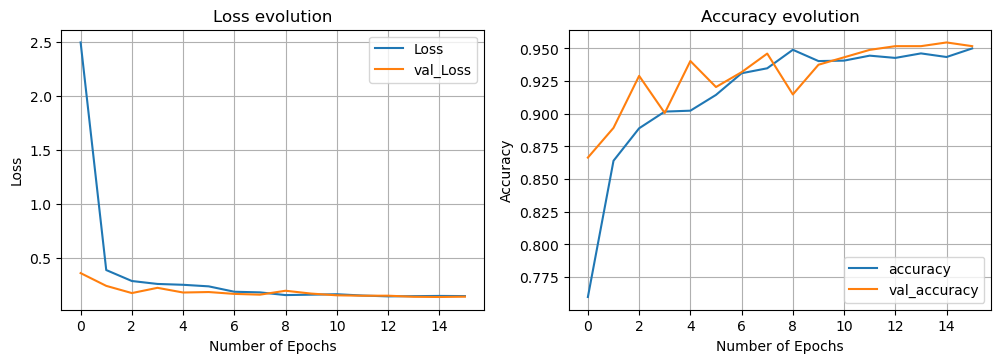

In [53]:
visualize_performance(h)

In [54]:
model.evaluate(test_generator)

12/12 [==============================] - 51s 4s/step - loss: 0.1499 - accuracy: 0.9563


[0.14992329478263855, 0.9562841653823853]

In [55]:
predictions = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size)
predictions

11/11 [==============================] - 54s 4s/step


array([[1.40694773e-03],
       [4.56179818e-03],
       [3.18659404e-05],
       [9.65355895e-03],
       [2.86938459e-01],
       [4.79101725e-02],
       [1.38790892e-06],
       [8.29679193e-05],
       [5.08910697e-03],
       [3.51787057e-05],
       [4.06416366e-04],
       [3.73402463e-06],
       [1.14849605e-01],
       [1.81674976e-02],
       [1.11958629e-03],
       [1.24395790e-03],
       [7.46151773e-06],
       [4.43125330e-03],
       [1.12608968e-05],
       [2.09695729e-03],
       [4.27622683e-02],
       [1.39474878e-07],
       [4.53617215e-01],
       [2.51949183e-03],
       [4.51205391e-03],
       [2.04547105e-04],
       [1.76532087e-08],
       [1.90063613e-04],
       [2.58229382e-04],
       [7.03070720e-04],
       [9.32080269e-01],
       [3.72311391e-04],
       [7.15770796e-07],
       [5.09387031e-02],
       [1.69066302e-02],
       [9.33932483e-01],
       [5.09813707e-03],
       [8.28122914e-01],
       [9.97290699e-05],
       [8.72648001e-01],


In [56]:
predicted_classes = []
for element in predictions:
    if element > 0.5:
        predicted_classes.append(1)
    else:
        predicted_classes.append(0)
    
predicted_classes[:30]
# predicted_classes = [np.argmax(pred) for pred in predictions]
# predicted_classes[:30]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [57]:
true_classes = test_generator.classes
true_classes[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [58]:
class_labels_test_data = list(test_generator.class_indices.keys())
class_labels_test_data

['DR', 'No_DR']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

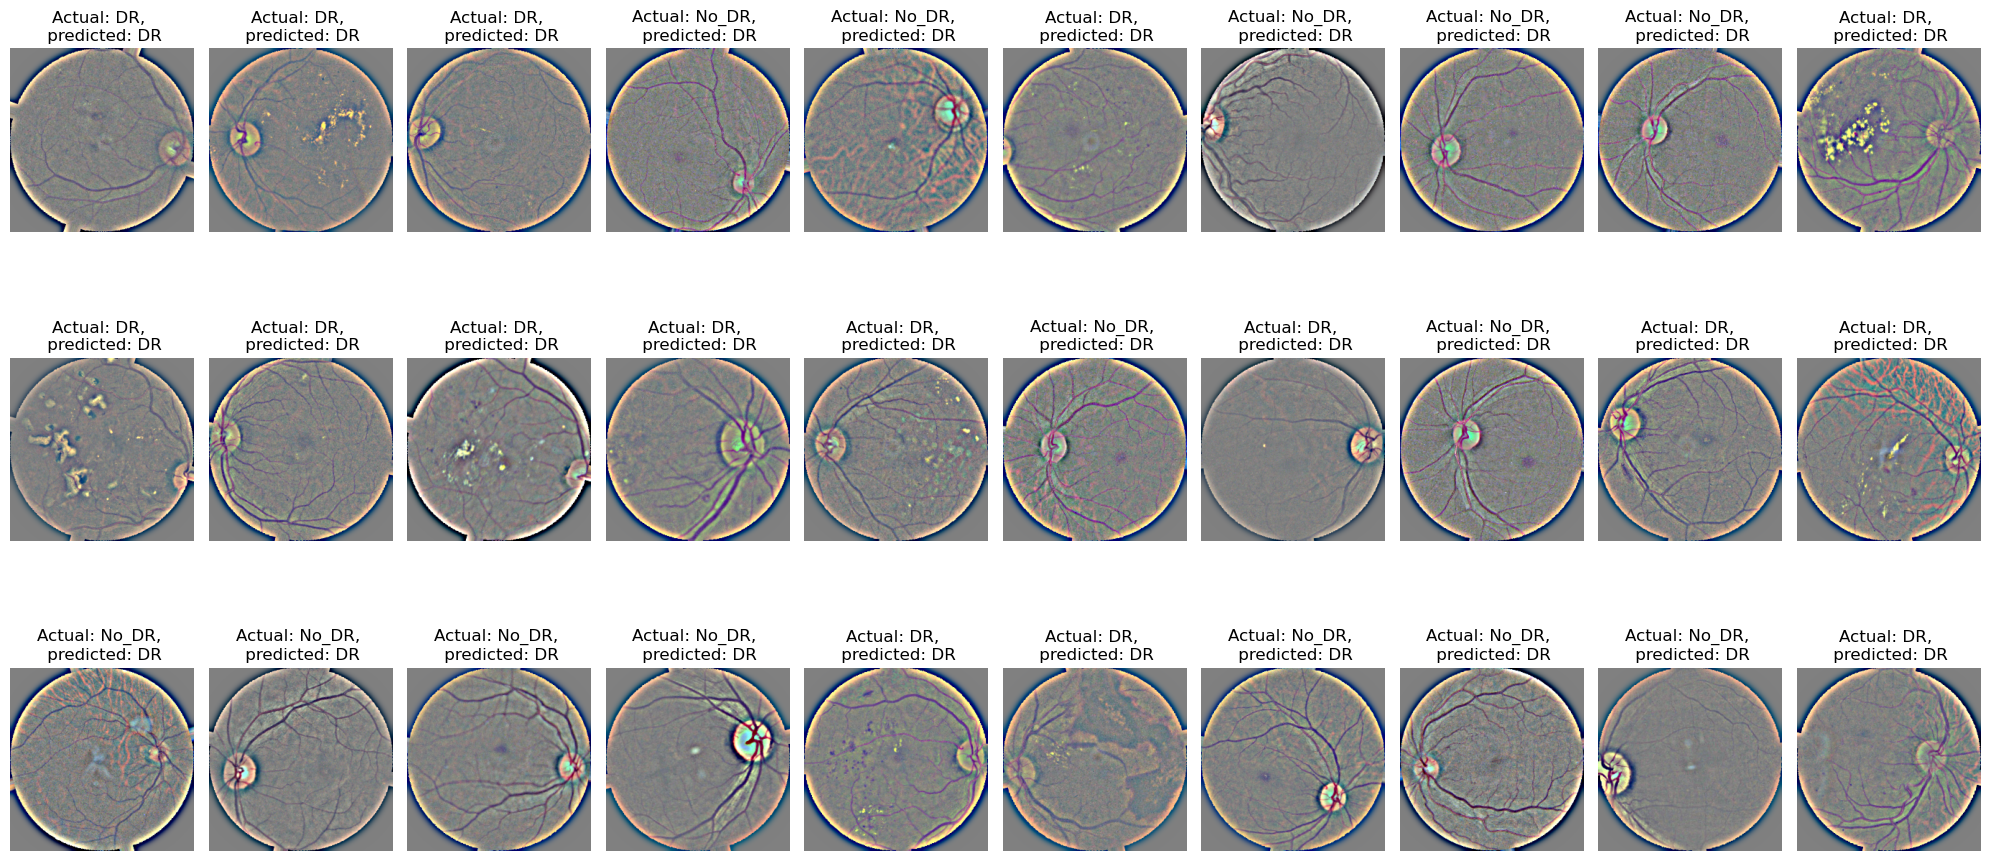

In [59]:
# Get the next batch of images and labels from the generator
# images, labels = test_generator.next()

# Display the first 30 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title('Actual: {}'.format(class_labels_test_data[int(labels[i])])+', \n predicted: {}'.format(class_labels_test_data[predicted_classes[i]]))
    ax.axis('off')

plt.tight_layout()
plt.show()

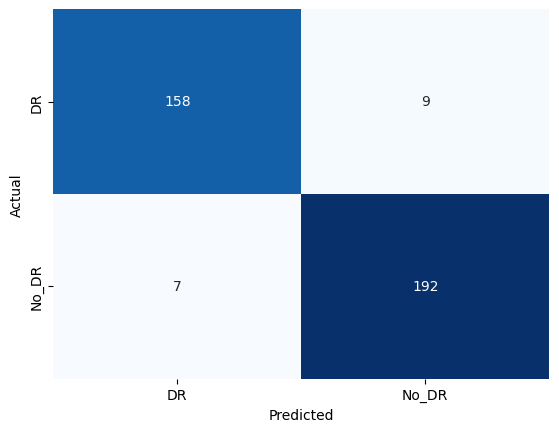

In [60]:
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels_test_data, yticklabels= class_labels_test_data, cbar = False, cmap = plt.cm.Blues,)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

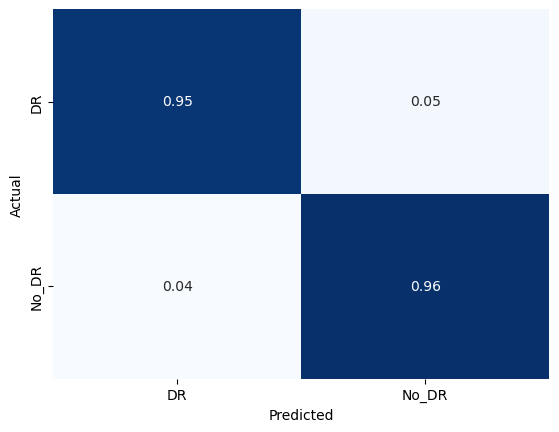

In [61]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_labels_test_data, yticklabels=class_labels_test_data, cbar = False,cmap = plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [62]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels_test_data)
print(report) 

              precision    recall  f1-score   support

          DR       0.96      0.95      0.95       167
       No_DR       0.96      0.96      0.96       199

    accuracy                           0.96       366
   macro avg       0.96      0.96      0.96       366
weighted avg       0.96      0.96      0.96       366



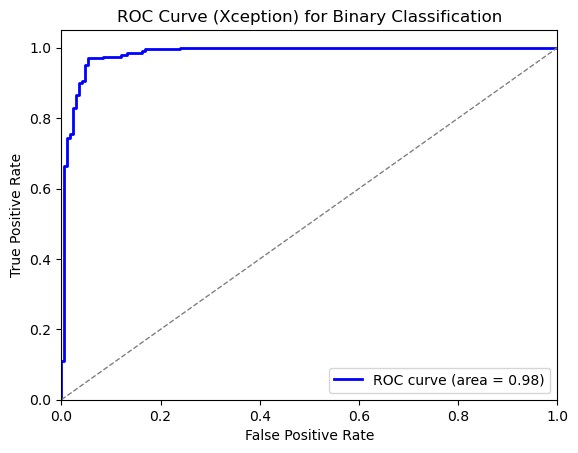

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Xception) for Binary Classification')
plt.legend(loc='lower right')
plt.show()


In [64]:
#experiment 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

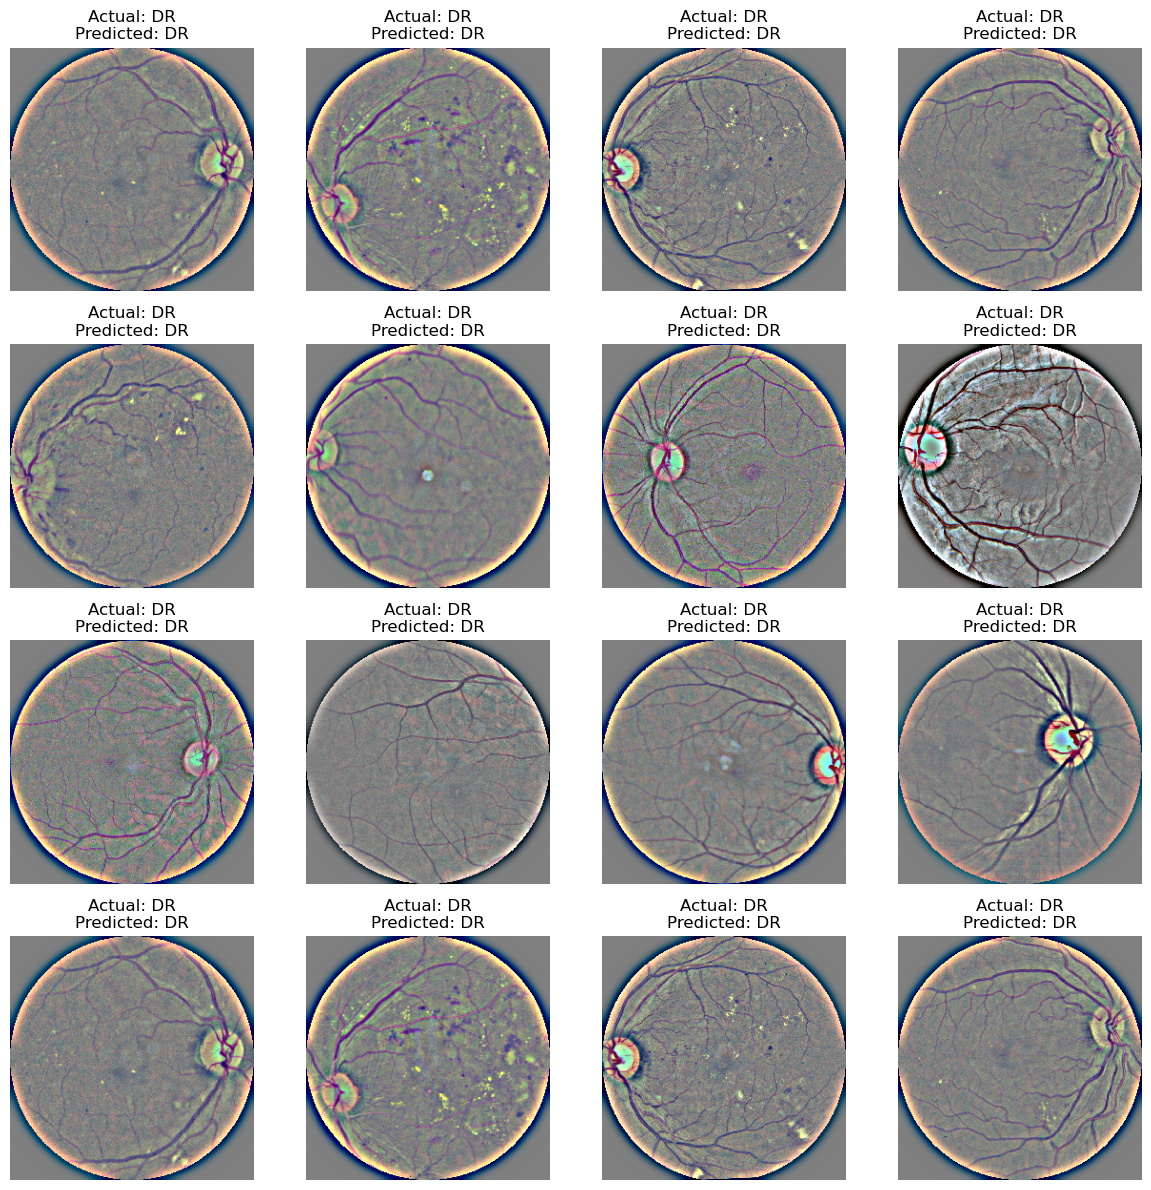

In [65]:

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Display the images with actual and predicted labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
axes = axes.flatten()

for i, (image, label) in enumerate(test_generator):
    if i >= 16:
        break
    
    # Get the actual and predicted labels
    actual_label = class_labels[np.argmax(label[0])]
    predicted_label = class_labels[predicted_classes[i]]
    
    # Display the image with labels
    axes[i].imshow(image[0])
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()